In [1]:
import numpy as np
import tensorflow as tf
from transformer import Encoding, Decoding
from tensorflow.keras import layers, optimizers

In [2]:
# 数据模拟(一维数据)

x = np.arange(0, 1000, 0.5)
y = np.cos(x) + np.sin(x)

In [3]:
# 数据预处理

class create_data(object):
    def __init__(self, data, split_percentage, input_length, output_length):
        """
        :params data: 传入一维数据
        :params split_percentage: 数据集切割百分比
        :params input_length: 传入编码层的长度
        :params output_length: 传入解码层的长度(强制教学所需长度、预测长度)
        """
        train = data[:int(split_percentage*len(data))]
        test = data[int(split_percentage*len(data)):]
        self.xtrain ,self.ytrain, self.train_label = self.structurize(train, input_length, output_length)
        self.xtest ,self.ytest, self.test_label = self.structurize(test, input_length, output_length)

    
    def structurize(self, data, input_length, output_length):
        """ 
        :params data: 传入数组
        :params input_length: 传入编码层的长度
        :params output_length: 传入解码层的长度(强制教学所需长度、预测长度)
        :return: 返回两个二维数组
        """
        x = []
        y = []
        label = []
        for i in range(len(data)-input_length-output_length):
            x.append(list(data[i:i+input_length]))
            y.append(list(data[i+input_length-1: i+input_length+output_length-1]))
            label.append(list(data[i+input_length: i+input_length+output_length]))
        
        x = np.array(x)
        x = np.reshape(x, (-1, input_length, 1))
        y = np.array(y)
        y = np.reshape(y, (-1, output_length, 1))
        label = np.array(label)
        label = np.reshape(label, (-1, output_length, 1))
        return x, y, label

In [4]:
data = create_data(y, 0.8, 200, 10)
xtrain, ytrain, train_label = data.xtrain, data.ytrain, data.train_label
xtest, ytest, test_label = data.xtest, data.ytest, data.test_label

In [5]:
# 实例化模型

encoding = Encoding(units=64, heads=1, length=200)
decoding = Decoding(units=64, heads=1, length=10)
linear = layers.Dense(1)

# 初始化优化器
optimizer = optimizers.Adam(1e-3)

In [6]:
for _ in range(100):
    with tf.GradientTape() as tape:
        ec = encoding(xtrain)
        out = decoding(ec, ytrain)
        out = linear(out)
        loss = tf.reduce_mean((train_label-out)**2)
    grads = tape.gradient(loss, [*encoding.trainable_variables, *decoding.trainable_variables, *linear.trainable_variables])
    optimizer.apply_gradients(zip(grads, [*encoding.trainable_variables, *decoding.trainable_variables, *linear.trainable_variables]))
    ec_ = encoding(xtest)
    out_ = decoding(ec_, ytest)
    out_ = linear(out_)
    loss_ = tf.reduce_mean((test_label-out_)**2)
    print('train_loss='+str(loss.numpy())+ '  '+'test_loss='+str(loss_.numpy()))

train_loss=2.6714315  test_loss=0.79101795
train_loss=0.79331064  test_loss=0.99856305
train_loss=1.0019611  test_loss=0.8770739
train_loss=0.88006026  test_loss=0.49147126
train_loss=0.49366835  test_loss=0.28438103
train_loss=0.28548172  test_loss=0.28959343
train_loss=0.2896373  test_loss=0.31237012
train_loss=0.3117403  test_loss=0.26136684
train_loss=0.26047343  test_loss=0.19314356
train_loss=0.19228885  test_loss=0.17483851
train_loss=0.17427532  test_loss=0.19951287
train_loss=0.19928078  test_loss=0.21273232
train_loss=0.21271373  test_loss=0.1847822
train_loss=0.18464148  test_loss=0.13443862
train_loss=0.13398914  test_loss=0.09982518
train_loss=0.09891496  test_loss=0.09869645
train_loss=0.0975148  test_loss=0.11541613
train_loss=0.11420763  test_loss=0.12141839
train_loss=0.12034356  test_loss=0.10469362
train_loss=0.10377271  test_loss=0.076441966
train_loss=0.07573275  test_loss=0.05633611
train_loss=0.055744838  test_loss=0.054123405
train_loss=0.053630434  test_loss=0.

In [7]:
# 测试集绘图

import matplotlib.pyplot as plt

encod = encoding(xtest)
out = decoding(encod, ytest)
out = linear(out)

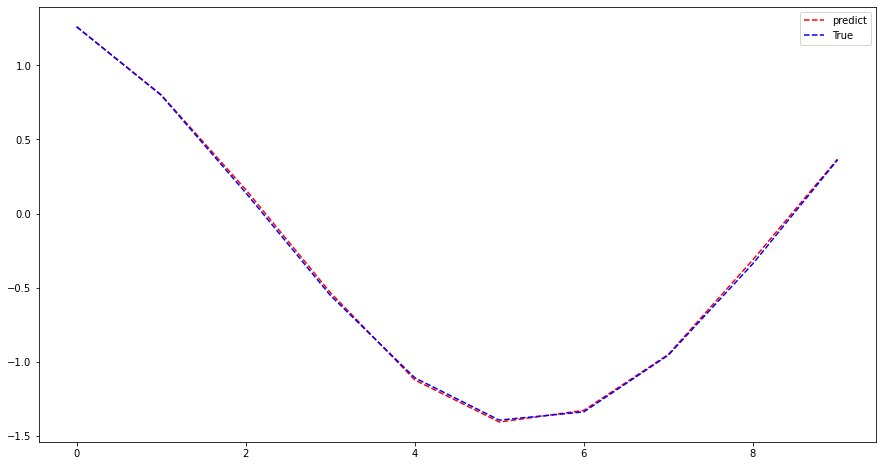

In [8]:
fig = plt.figure(figsize=(15, 8))
pre = np.reshape(out[-2].numpy(), (1, -1))[0]
true = np.reshape(test_label[-2], (1, -1))[0]
plt.plot(pre, color='red', linestyle='--', label='predict')
plt.plot(true, color='blue', linestyle='--', label='True')
plt.legend(loc='best')
plt.show()

### 预测
### $输入(编码数据:A_1, A_2, A_3, A_4,..,A_n)$ + $(标签数据: A_n, B_1, B_2,...,B_m)$ -> (预测数据: $\hat{A}_{n+1},...,B$) 其中B所有标签为任意一个实数， 使用改框架时必须要用任意实数去填满后面的标签数据, 所以在预测的时候只需取第一个预测数据即可, 在将预测数据塞入输出端:
### $$输入(A_2, A_3, A_4,..,A_n, \hat{A}_{n+1}) + (标签: \hat{A}_{n+1}, B_1....B_m) -> (预测: \hat{A}_{n+2},...,B)$$

In [9]:
def predict(data):
    """
    :params data: 传入三维数据
    """
    A = np.reshape(data, (1, -1))[0][-1]
    s = np.random.randn(9)
    A = np.array([A])
    label = np.concatenate([A, s])
    label = np.reshape(label, (1, -1, 1))
    out = encoding(data)
    out = decoding(out, label)
    out = linear(out)
    pre = tf.reshape(out, (1, -1))[0].numpy()[0]
    return pre

In [10]:
df = np.reshape(xtest[-1], (1, -1, 1))
predict(df)

0.77812105

In [11]:
class prediction(object):
    def __init__(self, data):
        self.data = data
        self.encoding = encoding
        self.decoding = decoding
        self.linear = linear
    
    def predict(self, data):
        """
        :params data: 传入三维数据
        """
        A = np.reshape(data, (1, -1))[0][-1]
        s = np.random.randn(9)
        A = np.array([A])
        label = np.concatenate([A, s])
        label = np.reshape(label, (1, -1, 1))
        out = encoding(data)
        out = decoding(out, label)
        out = linear(out)
        pre = tf.reshape(out, (1, -1))[0].numpy()[0]
        return pre
    
    def call(self, num):
        """
        :params num: 预测次数(最多十次)
        """
        result = []
        data = self.data
        for _ in range(num):
            out = self.predict(data)
            result.append(out)
            data = data[:, 1:, :]
            out = np.array([[[out]]])
            data = np.concatenate([data, out], axis=1)
        return result
            

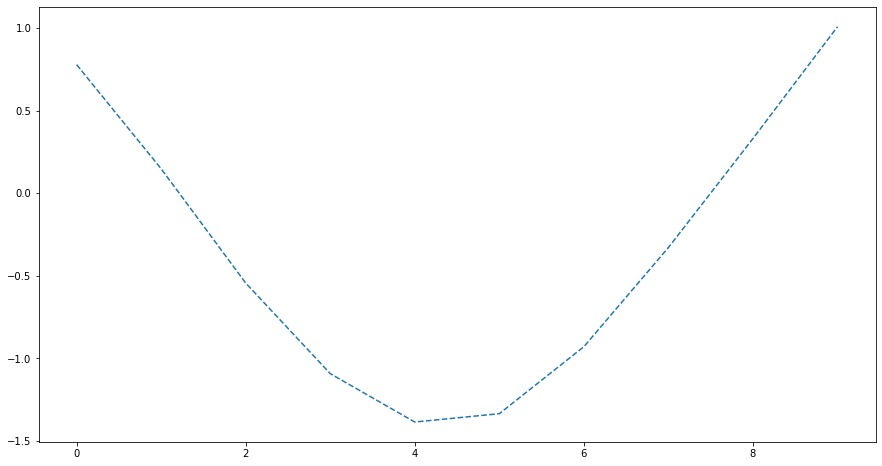

In [12]:
k = prediction(df)
p = k.call(10)
fig = plt.figure(figsize=(15, 8))
plt.plot(p, linestyle='--')
plt.show()